In [1]:
import os
import pandas as pd
from gneiss.regression import OLSModel
import seaborn as sns
import qiime2
from biom import load_table
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
data_dir = '../data/'
results_dir = '../results/'
mapping_fname = 'glen-canyon-metadata.tsv'

model16S_fname = 'glen-canyon-16S.linear_model.qza'
model18S_fname = 'glen-canyon-18S.linear_model.qza'
taxa16S_fname = 'taxonomy-qiime1.qza'
taxa18S_fname = 'euk-taxonomy-qiime1.qza'

model16S_fname = os.path.join(results_dir, model16S_fname)
model18S_fname = os.path.join(results_dir, model18S_fname)
mapping_fname = os.path.join(data_dir, mapping_fname)
taxa16S_fname = os.path.join(data_dir, 'taxonomy-qiime1.qza')
taxa18S_fname = os.path.join(data_dir, 'euk-taxonomy-qiime1.qza')

mapping = pd.read_table(mapping_fname, index_col=0,
                        na_values=['not applicable'])
model16S = qiime2.Artifact.load(model16S_fname)
model18S = qiime2.Artifact.load(model18S_fname)

reg_model16S = model16S.view(OLSModel)
reg_model18S = model18S.view(OLSModel)

taxonomy16S = qiime2.Artifact.load(taxa16S_fname).view(pd.DataFrame)
taxonomy18S = qiime2.Artifact.load(taxa18S_fname).view(pd.DataFrame)

Split up the taxonomies

In [3]:
def split_taxa(mapping):
    columns=['kingdom', 'phylum', 'class', 'order', 
             'family', 'genus', 'species']
    
    def pad_taxa(taxa_list):
        if len(taxa_list) < 7:
            taxa_blank = ['k__', 'p__', 'c__', 'o__', 'f__', 'g__', 's__']    
            return taxa_list + taxa_blank[-(7-len(taxa_list)):]    
        else:
            return taxa_list
    for k in columns:
        mapping[k] = ''
    for k in mapping.index:
        t = mapping.loc[k, 'Taxon']
        pt = pad_taxa(t.split(';'))        
        mapping.loc[k, columns] = pt
    return mapping

In [4]:
taxonomy16S = split_taxa(taxonomy16S)
taxonomy18S = split_taxa(taxonomy18S)

# 16S analysis

Interesting candidates include y0, y2, y6, y14

In [93]:
data = pd.merge(mapping, reg_model16S.balances, left_index=True, right_index=True)
df = data[['site_number', 'Site_Name', 'Type', 'y0', 'y2', 'y6', 'y14']]
df = df.reset_index() 
df = pd.melt(df, id_vars=['index','site_number', 'Type', 'Site_Name'], 
             var_name='balance', value_name='magnitude',
             value_vars=['y0', 'y2', 'y6', 'y14'])
df = df.set_index('index')

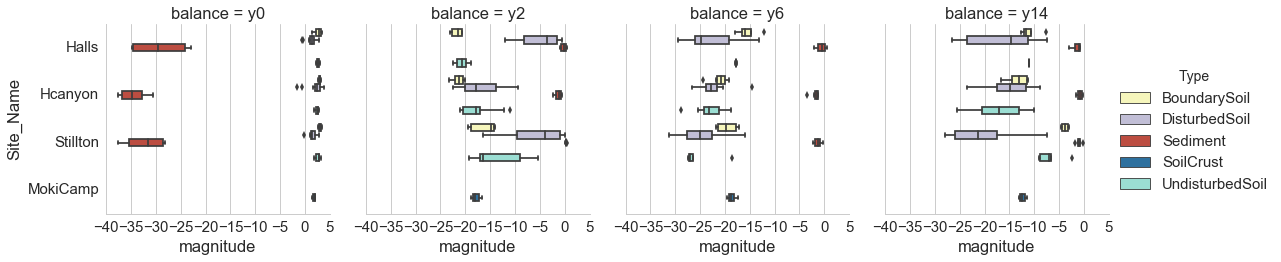

In [94]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
plt.rc('text', usetex=False)
fig = sns.factorplot(y='Site_Name', x='magnitude', hue='Type', col='balance',
                     data=df, kind='box',             
                     palette={'BoundarySoil': '#ffffb3',
                              'DisturbedSoil': '#bebada',
                              'UndisturbedSoil': '#90e9da',
                              'Sediment': '#d13d2c',
                              'SoilCrust': '#1b74b2'})
fig.savefig('../results/16S_top_balances.pdf')

# Sediments

In [95]:
left = taxonomy16S.loc[reg_model16S.tree.find('y0').children[0].subset()]
right = taxonomy16S.loc[reg_model16S.tree.find('y0').children[1].subset()]

n=6
vl = left.order.value_counts()
other = vl.iloc[n:].sum()
vl = vl.head(n=n)
vl = vl.rename(index={'o__': 'o__unknown'})
vl.index = list(map(lambda x: x[3:], vl.index))
vl.loc['other'] = other
vl = vl.reset_index()

vr = right.order.value_counts()
other = vr.iloc[n:].sum()
vr = vr.head(n=n)
vr = vr.rename(index={'o__': 'o__unknown'})
vr.index = list(map(lambda x: x[3:], vr.index))
vr.loc['other'] = other
vr = vr.reset_index()

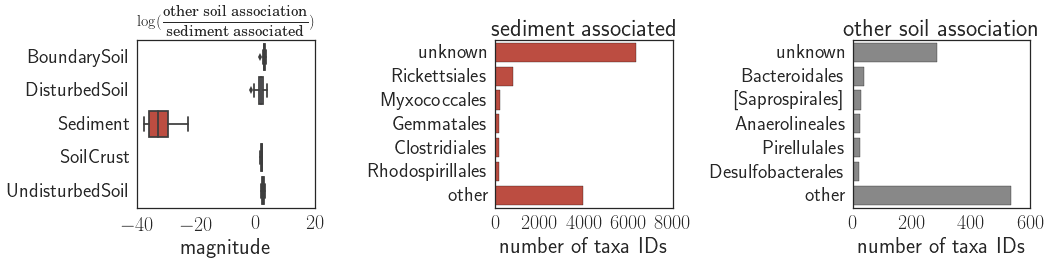

In [96]:
sns.set(font_scale=2) 
sns.set_style("white")

plt.rc('text', usetex=True)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 3))
gs = gridspec.GridSpec(100, 100)
ax1 = plt.subplot(gs[:, :20])
ax2 = plt.subplot(gs[:, 40:60])
ax3 = plt.subplot(gs[:, 80:])

sns.boxplot(x='y0', y='Type',data=data, ax=ax1, 
            palette={'BoundarySoil': '#ffffb3',
                     'DisturbedSoil': '#bebada',
                     'UndisturbedSoil': '#90e9da',
                     'Sediment': '#d13d2c',
                     'SoilCrust': '#1b74b2'})

ax2.set_title(r"sediment associated")
sns.barplot(y='index', x='order', data=vr, ax=ax2, color='#d13d2c')
ax3.set_title(r"other soil association")
sns.barplot(y='index', x='order', data=vl, ax=ax3, color='#888888')

#
ax1.set_title(r"$\displaystyle\log(\frac{\textrm{other soil association}}{\textrm{sediment associated}})$",
              fontsize=15)
ax1.set_xlabel("magnitude")
ax1.set_ylabel("")
ax2.set_xlabel("number of taxa IDs")#bebada
ax2.set_ylabel("")
#ax3.set_xlim([0, 800])
ax3.set_xlabel("number of taxa IDs")
ax3.set_ylabel("")
#ax3.set_xlim([0, 800])
ax1.locator_params(axis='x', nbins=4)
ax2.locator_params(axis='x', nbins=4)
ax3.locator_params(axis='x', nbins=4)
f.savefig('../results/16S/sediment_y0.pdf')
f.savefig('../results/16S/sediment_y0.png')

# Disturbed Soils

In [97]:
left = taxonomy16S.loc[reg_model16S.tree.find('y2').children[0].subset()]
right = taxonomy16S.loc[reg_model16S.tree.find('y2').children[1].subset()]

n=6
vl = left.order.value_counts()
other = vl.iloc[n:].sum()
vl = vl.head(n=n)
vl = vl.rename(index={'o__': 'o__unknown'})
vl.index = list(map(lambda x: x[3:], vl.index))
vl.loc['other'] = other
vl = vl.reset_index()

vr = right.order.value_counts()
other = vr.iloc[n:].sum()
vr = vr.head(n=n)
vr = vr.rename(index={'o__': 'o__unknown'})
vr.index = list(map(lambda x: x[3:], vr.index))
vr.loc['other'] = other
vr = vr.reset_index()

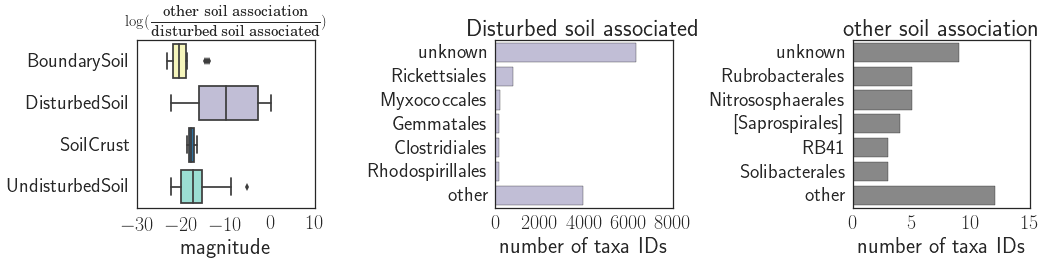

In [98]:
sns.set(font_scale=2) 
sns.set_style("white")

plt.rc('text', usetex=True)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 3))
gs = gridspec.GridSpec(100, 100)
ax1 = plt.subplot(gs[:, :20])
ax2 = plt.subplot(gs[:, 40:60])
ax3 = plt.subplot(gs[:, 80:])
# We will exclude the sediments!
subdata = data.loc[data.Type!='Sediment']

sns.boxplot(x='y2', y='Type',data=subdata, ax=ax1, 
            palette={'BoundarySoil': '#ffffb3',
                     'DisturbedSoil': '#bebada',
                     'UndisturbedSoil': '#90e9da',
                     'SoilCrust': '#1b74b2'})

ax2.set_title(r"Disturbed soil associated")
sns.barplot(y='index', x='order', data=vr, ax=ax2, color='#bebada')
ax3.set_title(r"other soil association")
sns.barplot(y='index', x='order', data=vl, ax=ax3, color='#888888')

#
ax1.set_title(r"$\displaystyle\log(\frac{\textrm{other soil association}}{\textrm{disturbed soil associated}})$",
              fontsize=15)
ax1.set_xlabel("magnitude")
ax1.set_ylabel("")
ax2.set_xlabel("number of taxa IDs")
ax2.set_ylabel("")
#ax3.set_xlim([0, 8000])
ax3.set_xlabel("number of taxa IDs")
ax3.set_ylabel("")
#ax3.set_xlim([0, 8000])
ax1.locator_params(axis='x', nbins=4)
ax2.locator_params(axis='x', nbins=4)
ax3.locator_params(axis='x', nbins=4)
f.savefig('../results/16S/disturbed_soil_y2.pdf')
f.savefig('../results/16S/disturbed_soil_y2.png')

Now we will just look at the Disturbed soil

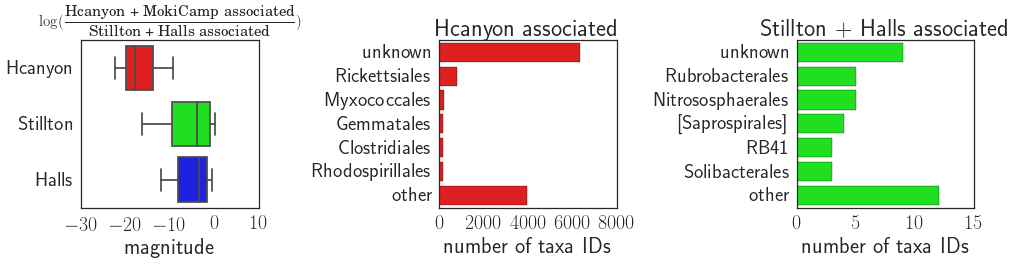

In [99]:
sns.set(font_scale=2) 
sns.set_style("white")

plt.rc('text', usetex=True)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 3))
gs = gridspec.GridSpec(100, 100)
ax1 = plt.subplot(gs[:, :20])
ax2 = plt.subplot(gs[:, 40:60])
ax3 = plt.subplot(gs[:, 80:])
# We will exclude the sediments!
subdata = data.loc[data.Type=='DisturbedSoil']
sns.boxplot(x='y2', y='Site_Name',data=subdata, ax=ax1, 
            palette={'Hcanyon': "#FF0000",
                     'MokiCamp': "#FFFF00",
                     'Stillton': "#00FF00",    
                     'Halls': "#0000FF"})

ax2.set_title(r"Hcanyon associated")
sns.barplot(y='index', x='order', data=vr, ax=ax2, color='#FF0000')
ax3.set_title(r"Stillton + Halls associated")
sns.barplot(y='index', x='order', data=vl, ax=ax3, color='#00FF00')

#
ax1.set_title(r"$\displaystyle\log(\frac{\textrm{Hcanyon + MokiCamp associated}}{\textrm{Stillton + Halls associated}})$", 
              fontsize=15)
ax1.set_xlabel("magnitude")
ax1.set_ylabel("")
ax2.set_xlabel("number of taxa IDs")
ax2.set_ylabel("")
#ax3.set_xlim([0, 8000])
ax3.set_xlabel("number of taxa IDs")
ax3.set_ylabel("")
#ax3.set_xlim([0, 8000])
ax1.locator_params(axis='x', nbins=4)
ax2.locator_params(axis='x', nbins=4)
ax3.locator_params(axis='x', nbins=4)
f.savefig('../results/16S/disturbed_soil_sites_y2.pdf')
f.savefig('../results/16S/disturbed_soil_sites_y2.png')

# Heatmap

Run heatmaps to visualize differences between types
```
qiime gneiss dendrogram-heatmap \
    --i-table results/glen-canyon-16S.composition.qza \
    --i-tree results/glen-canyon-16S.proportional_tree.nwk.qza \
    --m-metadata-file data/glen-canyon-metadata.tsv \
    --m-metadata-category "Type" \
    --o-visualization results/glen-canyon-16S-heatmap-type
    
```
Run heatmaps to visualize differences between sites
```
qiime gneiss dendrogram-heatmap \
    --i-table results/glen-canyon-16S.composition.qza \
    --i-tree results/glen-canyon-16S.proportional_tree.nwk.qza \
    --m-metadata-file data/glen-canyon-metadata.tsv \
    --m-metadata-category "Site_Name" \
    --o-visualization results/glen-canyon-16S-heatmap-site
```


# 18S analysis

Interesting candidates include y1, y4, y5, y6, y14

In [100]:
data = pd.merge(mapping, reg_model18S.balances, left_index=True, right_index=True)
df = data[['site_number', 'Site_Name', 'Type', 'y1', 'y4', 'y5', 'y6', 'y14']]
df = df.reset_index() 
df = pd.melt(df, id_vars=['index','site_number', 'Type', 'Site_Name'], 
             var_name='balance', value_name='magnitude',
             value_vars=['y1', 'y4', 'y5', 'y6', 'y14'])
df = df.set_index('index')

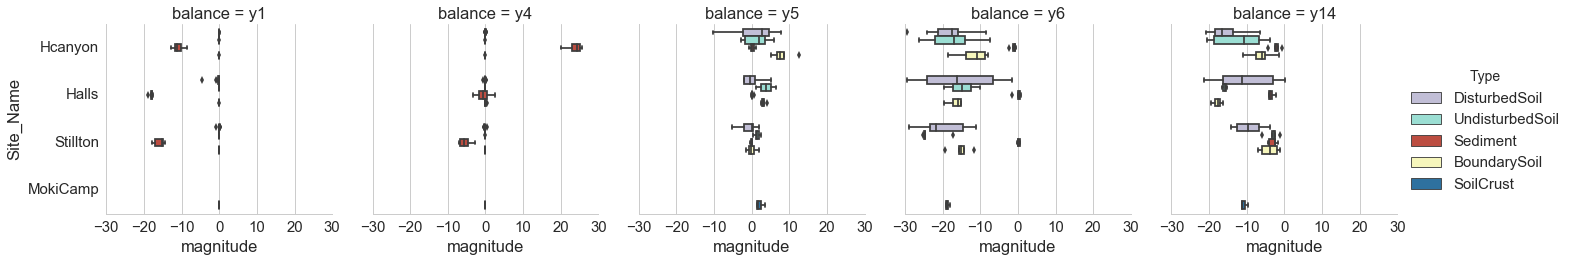

In [101]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
plt.rc('text', usetex=False)
fig = sns.factorplot(y='Site_Name', x='magnitude', hue='Type', col='balance',
                     data=df, kind='box',             
                     palette={'BoundarySoil': '#ffffb3',
                              'DisturbedSoil': '#bebada',
                              'UndisturbedSoil': '#90e9da',
                              'Sediment': '#d13d2c',
                              'SoilCrust': '#1b74b2'})
fig.savefig('../results/18S/18S_top_balances.pdf')

# Sediments

In [102]:
left = taxonomy18S.loc[reg_model18S.tree.find('y0').children[0].subset()]
right = taxonomy18S.loc[reg_model18S.tree.find('y0').children[1].subset()]

n=6
vl = left.order.value_counts()
other = vl.iloc[n:].sum()
vl = vl.head(n=n)
vl = vl.rename(index={'o__': 'o__unknown'})
vl.index = list(map(lambda x: x.split('__')[1], vl.index))
vl.loc['other'] = other
vl = vl.reset_index()

vr = right.order.value_counts()
other = vr.iloc[n:].sum()
vr = vr.head(n=n)
vr = vr.rename(index={'o__': 'o__unknown'})
vr.index = list(map(lambda x: x.split('__')[1], vr.index))
vr.loc['other'] = other
vr = vr.reset_index()

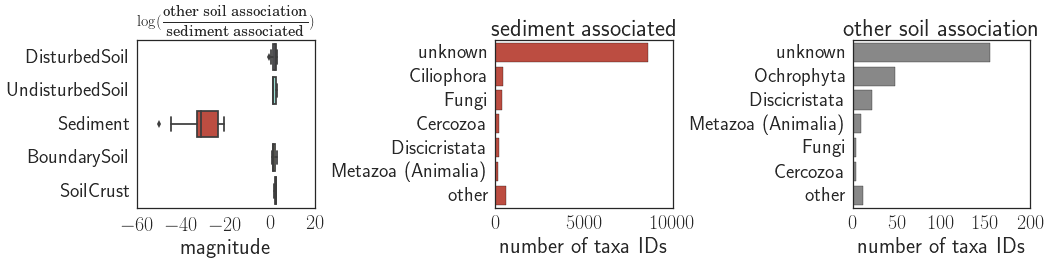

In [103]:
sns.set(font_scale=2) 
sns.set_style("white")

plt.rc('text', usetex=True)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 3))
gs = gridspec.GridSpec(100, 100)
ax1 = plt.subplot(gs[:, :20])
ax2 = plt.subplot(gs[:, 40:60])
ax3 = plt.subplot(gs[:, 80:])

sns.boxplot(x='y0', y='Type',data=data, ax=ax1, 
            palette={'BoundarySoil': '#ffffb3',
                     'DisturbedSoil': '#bebada',
                     'UndisturbedSoil': '#90e9da',
                     'Sediment': '#d13d2c',
                     'SoilCrust': '#1b74b2'})

ax2.set_title(r"sediment associated")
sns.barplot(y='index', x='order', data=vr, ax=ax2, color='#d13d2c')
ax3.set_title(r"other soil association")
sns.barplot(y='index', x='order', data=vl, ax=ax3, color='#888888')

#
ax1.set_title(r"$\displaystyle\log(\frac{\textrm{other soil association}}{\textrm{sediment associated}})$",
              fontsize=15)
ax1.set_xlabel("magnitude")
ax1.set_ylabel("")
ax2.set_xlabel("number of taxa IDs")#bebada
ax2.set_ylabel("")
#ax3.set_xlim([0, 800])
ax3.set_xlabel("number of taxa IDs")
ax3.set_ylabel("")
#ax3.set_xlim([0, 800])
ax1.locator_params(axis='x', nbins=4)
ax2.locator_params(axis='x', nbins=4)
ax3.locator_params(axis='x', nbins=4)
f.savefig('../results/18S/sediment_y1.pdf')
f.savefig('../results/18S/sediment_y1.png')

# Sites

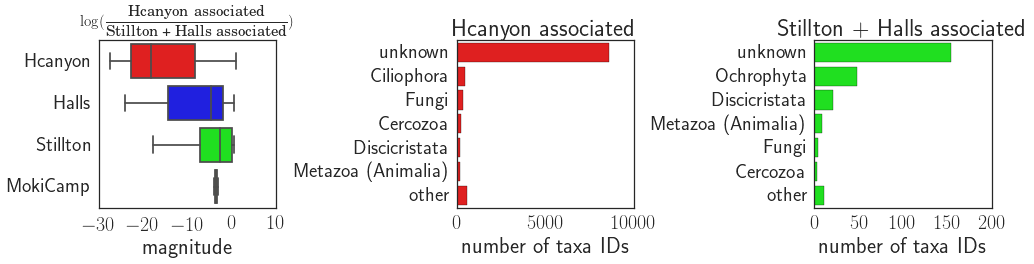

In [104]:
sns.set(font_scale=2) 
sns.set_style("white")

plt.rc('text', usetex=True)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 3))
gs = gridspec.GridSpec(100, 100)
ax1 = plt.subplot(gs[:, :20])
ax2 = plt.subplot(gs[:, 40:60])
ax3 = plt.subplot(gs[:, 80:])

sns.boxplot(x='y2', y='Site_Name',data=data, ax=ax1, 
            palette={'Hcanyon': "#FF0000",
                     'MokiCamp': "#FFFF00",
                     'Stillton': "#00FF00",    
                     'Halls': "#0000FF"})

ax2.set_title(r"Hcanyon associated")
sns.barplot(y='index', x='order', data=vr, ax=ax2, color='#FF0000')
ax3.set_title(r"Stillton + Halls associated")
sns.barplot(y='index', x='order', data=vl, ax=ax3, color='#00FF00')

ax1.set_title(r"$\displaystyle\log(\frac{\textrm{Hcanyon associated}}{\textrm{Stillton + Halls associated}})$",
              fontsize=15)
ax1.set_xlabel("magnitude")
ax1.set_ylabel("")
ax2.set_xlabel("number of taxa IDs")#bebada
ax2.set_ylabel("")
#ax3.set_xlim([0, 800])
ax3.set_xlabel("number of taxa IDs")
ax3.set_ylabel("")
#ax3.set_xlim([0, 800])
ax1.locator_params(axis='x', nbins=4)
ax2.locator_params(axis='x', nbins=4)
ax3.locator_params(axis='x', nbins=4)
f.savefig('../results/18S/sites_y4.pdf')
f.savefig('../results/18S/sites_y4.png')

# Heatmap
To visualize heatmaps with respect to soil type
```
qiime gneiss dendrogram-heatmap \
    --i-table results/glen-canyon-18S.composition.qza \
    --i-tree results/glen-canyon-18S.proportional_tree.nwk.qza \
    --m-metadata-file data/glen-canyon-metadata.tsv \
    --m-metadata-category "Type" \
    --o-visualization results/glen-canyon-18S-heatmap
```
To visualize heatmaps with respect to site name
```
qiime gneiss dendrogram-heatmap \
    --i-table results/glen-canyon-18S.composition.qza \
    --i-tree results/glen-canyon-18S.proportional_tree.nwk.qza \
    --m-metadata-file data/glen-canyon-metadata.tsv \
    --m-metadata-category "Type" \
    --o-visualization results/glen-canyon-18S-heatmap
```